In [83]:
import os
import glob
import netCDF4
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.colors as colors

In [159]:
################################################################################
# Load Data ERA5
################################################################################
os.chdir('D:\\MEGA\\UBUNTU\\Jupyter\\GRUPOANTARTICO\\PCPscaling')
filename_ERA5_1 = 'ERA5_PCPScaling_EastPeninsula_1.nc'
filename_ERA5_2 = 'ERA5_PCPScaling_EastPeninsula_2.nc'
filename_ERA5_3 = 'ERA5_PCPScaling_EastPeninsula_3.nc'
filename_ERA5_4 = 'ERA5_PCPScaling_EastPeninsula_4.nc'

#Load netcdf
ncdf1 = netCDF4.Dataset(filename_ERA5_1)
ncdf2 = netCDF4.Dataset(filename_ERA5_2)
ncdf3 = netCDF4.Dataset(filename_ERA5_3)
ncdf4 = netCDF4.Dataset(filename_ERA5_4)

#Get dimension
ERA5_lon = ncdf1.variables['longitude'][:]
ERA5_lat = ncdf1.variables['latitude'][:]
ERA5_times = np.concatenate((ncdf1.variables['time'][:], ncdf2.variables['time'][:], ncdf3.variables['time'][:], ncdf4.variables['time'][:]))

#Get variables
ERA5_pcp = np.concatenate((ncdf1.variables['tp'][:,0,0], ncdf2.variables['tp'][:,0,0], ncdf3.variables['tp'][:,0,0], ncdf4.variables['tp'][:,0,0]))
ERA5_pcp = ERA5_pcp*1000 #change units mm

#Calculate datetime
ERA5_dtimes = np.empty(len(ERA5_times), dtype='datetime64[h]')
for i,t in enumerate(ERA5_times):
    ERA5_dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
ERA5_dtimes = ERA5_dtimes.astype('datetime64')

################################################################################
# Calculate maxs
################################################################################
ERA5_PCP_c = ERA5_pcp.cumsum(axis=0) #cumsum

ERA5_duration = np.array([1,2,3,6,12,18,1*24,2*24,3*24,4*24,5*24,6*24,7*24,8*24,9*24,10*24,15*24,20*24,30*24,60*24,90*24,180*24,270*24,365*24,545*24,730*24])
ERA5_PCP_max = np.zeros(np.shape(ERA5_duration))
ERA5_PCP_n = ERA5_PCP_c[1:] - ERA5_PCP_c[:-1]
for i,n in enumerate(ERA5_duration):
    ERA5_PCP_n = ERA5_PCP_c[n:] - ERA5_PCP_c[:-n]
    ERA5_PCP_max[i] = ERA5_PCP_n.max()
print(ERA5_PCP_max)

[   2.85137817    5.69749157    8.4404414    15.19656342   22.5468637
   28.35943567   34.88917045   47.57811944   53.72588172   56.68143829
   67.87532162   74.57348754   77.76842105   82.2098011    83.89641038
   84.98083436   93.60726669  112.98625801  150.56817884  183.2582315
  251.84028358  378.68180049  503.29129041  609.02266824  869.08042635
 1090.25718417]


In [160]:
################################################################################
# Load Data ERAInt
################################################################################
os.chdir('D:\\MEGA\\UBUNTU\\Jupyter\\GRUPOANTARTICO\\PCPscaling')
filename_ERAInt = 'ERAInt_PCPScaling_EastPeninsula.nc'

#Load netcdf
ncdf = netCDF4.Dataset(filename_ERAInt)

#Get dimension
ERAInt_lon = ncdf.variables['longitude'][:]
ERAInt_lat = ncdf.variables['latitude'][:]
ERAInt_times = ncdf.variables['time'][:]
print(ncdf.variables)

#Get variables
ERAInt_pcp = ncdf.variables['tp'][:,0,0]
ERAInt_pcp = ERAInt_pcp*1000 #change units mm

#Calculate datetime
ERAInt_dtimes = np.empty(len(ERAInt_times), dtype='datetime64[h]')
for i,t in enumerate(ERAInt_times):
    ERAInt_dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
ERAInt_dtimes = ERAInt_dtimes.astype('datetime64')

################################################################################
# Calculate maxs
################################################################################
ERAInt_PCP_c = ERAInt_pcp.cumsum(axis=0) #cumsum

ERAInt_duration = np.array([1,2,2*2,3*2,4*2,5*2,6*2,7*2,8*2,9*2,10*2,15*2,20*2,30*2,60*2,90*2,180*2,270*2,365*2,545*2,730*2])
ERAInt_PCP_max = np.zeros(np.shape(ERAInt_duration))
ERAInt_PCP_n = ERAInt_PCP_c[1:] - ERAInt_PCP_c[:-1]
for i,n in enumerate(ERAInt_duration):
    ERAInt_PCP_n = ERAInt_PCP_c[n:] - ERAInt_PCP_c[:-n]
    ERAInt_PCP_max[i] = ERAInt_PCP_n.max()
print(ERAInt_PCP_max)

{'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: time
current shape = (29706,)
filling on, default _FillValue of -2147483647 used, 'tp': <class 'netCDF4._netCDF4.Variable'>
int16 tp(time, latitude, longitude)
    scale_factor: 3.534810667029522e-07
    add_offset: 0.01158216052704621
    _FillValue: -32767
    missing_value: -32767
    units: m
    long_name: Total precipitation
unlimited dimensions: time
curr

In [161]:
##Join PCP_max archives
os.chdir('D:\\Bigfiles\\RACMO2_PCP')
lats = np.genfromtxt('PCP_max_lats.csv', delimiter=';')
lons = np.genfromtxt('PCP_max_lons.csv', delimiter=';')
duration = np.genfromtxt('PCP_max_duration.csv', delimiter=';')

PCP_max = np.zeros((lats.shape[0], lats.shape[1], 20))
PCP_mean = np.zeros((lats.shape[0], lats.shape[1], 20))


files = 'PCP_max_*d.csv'
for i,file in enumerate(glob.glob(files)):
    print(file)
    PCP_max[:,:,i] = np.genfromtxt(file, delimiter=';')

files = 'PCP_mean_*d.csv'
for i,file in enumerate(glob.glob(files)):
    print(file)
    PCP_mean[:,:,i] = np.genfromtxt(file, delimiter=';')


    
Ant_max = np.max(np.max(PCP_max, axis=0), axis=0)
Ant_mean = np.mean(np.mean(PCP_mean, axis=0), axis=0)
print(Ant_max)
print(duration)

PCP_max_001d.csv
PCP_max_002d.csv
PCP_max_003d.csv
PCP_max_004d.csv
PCP_max_005d.csv
PCP_max_006d.csv
PCP_max_007d.csv
PCP_max_008d.csv
PCP_max_009d.csv
PCP_max_010d.csv
PCP_max_015d.csv
PCP_max_020d.csv
PCP_max_030d.csv
PCP_max_060d.csv
PCP_max_090d.csv
PCP_max_180d.csv
PCP_max_270d.csv
PCP_max_365d.csv
PCP_max_545d.csv
PCP_max_730d.csv
PCP_mean_001d.csv
PCP_mean_002d.csv
PCP_mean_003d.csv
PCP_mean_004d.csv
PCP_mean_005d.csv
PCP_mean_006d.csv
PCP_mean_007d.csv
PCP_mean_008d.csv
PCP_mean_009d.csv
PCP_mean_010d.csv
PCP_mean_015d.csv
PCP_mean_020d.csv
PCP_mean_030d.csv
PCP_mean_060d.csv
PCP_mean_090d.csv
PCP_mean_180d.csv
PCP_mean_270d.csv
PCP_mean_365d.csv
PCP_mean_545d.csv
PCP_mean_730d.csv
[  278.85875702   381.7191124    488.01956177   553.31954956
   612.95471191   655.94558716   690.80486298   744.23446655
   846.57726288   904.07524109  1151.98345184  1416.31965637
  1525.14095306  2131.20002747  2827.6594162   4752.63404846
  6200.19264221  7352.46963501 10269.8135376  13622.6898

[  38.82827461   55.11746407   55.44576645   55.75797558   62.91434392
   75.18005893   78.02385762   84.25820321   87.10200191   87.40668744
   93.67637783  101.24459267  119.29028034  178.50701809  223.3537674
  374.94256496  475.22993088  609.97102261  879.51564789 1073.05698395]
ANTARCTICA ERA-Int
a_sup = [12.31346061], a_inf = [7.05598782]
b = 0.5141396384191074
[  40.22719621   57.45015661   70.7663365    82.04699322   92.02121202
  101.06439169  109.40021224  117.17477363  124.48976943  131.41937644
  161.8806347   187.68555777  231.18856623  330.17014825  406.69918396
  580.82426848  715.45158539  835.4031157  1026.61988509 1193.07444592]
b: 0.5141396384191074     a: 2.2649985641296944
ANTARCTICA ERA5
a_sup = [0.89012227], a_inf = [0.53887603]
b = 0.5128264114806618
[  37.0801404    52.90753188   65.13609984   75.49073168   84.64311718
   92.93897601  100.58424608  107.71340803  114.42004959  120.77242353
  148.6866682   172.32326467  212.15250409  302.70827598  372.6735266
  5

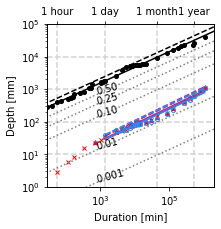

In [162]:
######################################
# Plot Scaling Law of a point
######################################

#args_m90_m170 = np.argwhere(lats == -90)[0]; print(args_m90_m170)

args_7500S_033W_DronningMaudLand = [120, 179]
args_7985S_9002E_HighPlateau = [171, 127]
args_6673S_11275E_LawDome = [222, 100]
args_7535S_12333E_DomeC = [185, 97]
args_7985S_17983E_RossIceShelf = [138, 80]
args_7026S_14999W_Ocean = [103, 46]
args_7968S_11233W_WAISDivide = [ 96, 98]
args_7406S_7086W_Gomez = [ 68, 130]
args_7001S_6673W_WestPeninsula = [ 53, 138]
args_6988S_6002W_EastPeninsula = [ 55, 147]

#print(lons[args_m90_m170args_m7985_m09002[0],args_m7985_m09002[1]]); print(lats[args_m90_m170args_m7985_m09002[0],args_m7985_m09002[1]])
point = args_6988S_6002W_EastPeninsula
pointname = 'East Peninsula'
PCPmax_args = PCP_max[point[0],point[1],:]
print(PCPmax_args)


class SL_Envelop():
    '''----BASIC METHODS----'''
    def __init__(self, duration, record):
        self._duration = duration
        self._record = record
        
    @property
    def duration (self):
        return self._duration     
    
    @property
    def record (self):
        return self._record
     
    def __str__(self):
        return 'DATA\n Duration: ' + self.duration + '\n Record: ' + self.record
    
    def regression(self, complete=False, ftype=0):
        '''Log-Log regression of data'''
        #Fit in log domain
        p = np.polyfit(np.log(self.duration),np.log(self.record),1)
        
        #Compute fit in linear domain (y = e^(p_1 * log(x) + p_2)
        if complete == False:
            y_hat = np.exp(p[0] * np.log(self.duration) + p[1])
        else:
            y_hat = np.exp(p[0] * np.log([1,10000000]) + p[1])
        
        if ftype == 3:
            return y_hat, p[1], p[0]
        elif ftype == 2:
            return p[1], p[0]      
        elif ftype == 1:
            return np.exp(p[1]), p[0]
        else:
            return y_hat, p
    
    def envelope(self, opt='both', range=[1,10000000], complete=False):
        '''Envelop of the supINSay data'''
        
        #Make the regression
        y_hat, a, b = self.regression(complete=False, ftype=3)
        
        #Superior Envelop
        Log_record_sup = np.log(self.record[np.where(self.record > y_hat)])
        Log_duration_sup = np.log(self.duration[np.where(self.record > y_hat)])
        dist = np.abs(b*Log_duration_sup - Log_record_sup + a) / np.sqrt(b**2 + 1)
        Max_record_sup = Log_record_sup[np.where(dist == np.amax(dist))]
        Max_duration_sup = Log_duration_sup[np.where(dist == np.amax(dist))]
        a_sup = b*(-Max_duration_sup) + Max_record_sup

        #Inferior Envelop
        Log_record_inf = np.log(self.record[np.where(self.record < y_hat)])
        Log_duration_inf = np.log(self.duration[np.where(self.record < y_hat)])
        dist = np.abs(b*Log_duration_inf - Log_record_inf + a) / np.sqrt(b**2 + 1)
        Max_record_inf = Log_record_inf[np.where(dist == np.amax(dist))]
        Max_duration_inf = Log_duration_inf[np.where(dist == np.amax(dist))]
        a_inf = b*(-Max_duration_inf) + Max_record_inf

        
        #Calculate the Envelope ecuation
        if complete == False:
            y_hat_sup = np.exp(b * np.log(self.duration) + a_sup)
            y_hat_inf = np.exp(b * np.log(self.duration) + a_inf)
        else:
            y_hat_sup = np.exp(b * np.log(range) + a_sup)
            y_hat_inf = np.exp(b * np.log(range) + a_inf)
        
        print('a_sup = ' + str(np.exp(a_sup)) + ', a_inf = ' + str(np.exp(a_inf)))
        print('b = ' + str(b))
        print(y_hat_sup)
        
        return y_hat_sup, y_hat_inf, a_sup, a_inf, b
        
        #return env_sup, env_inf 
        
    
    def formula(self, ftype=0):
        '''Show formula of regression'''
        _reg, p = self.regression()
        R2 = self.R2()
        b = p[0]
        a = np.exp(p[1])        
        
        #formula = 'y = '+str(np.round(a,2))+' EXP(x^'+str(np.round(b,2))+')'
        if ftype == 0:
            formula = '$y = '+str(np.round(a,2))+' x^{'+str(np.round(b,2))+'}$'
        elif ftype == 1:
            formula = '$b:'+str(np.round(b,2))+'$'
        elif ftype == 2:
            formula = '$b:'+str(np.round(b,2))+' a:'+str(np.round(a,2))+'$'
        elif ftype == 3:
            formula = '$R^{2}:'+str(np.round(R2,2))+'$'
        
        return formula
    
    def exponent(self):
        _reg, p = self.regression()
        b = p[0]
        
        return b
    
    def R2(self):
        X = np.log(np.array(self.duration))
        Y = np.log(np.array(self.record))
        n = np.size(X)
        A = np.sum(X*Y) - 1/n * np.sum(X) * np.sum(Y)
        B = np.sum(X**2) - 1/n * np.sum(X)**2
        C = np.sum(Y**2) - 1/n * np.sum(Y)**2
        
        return A**2 / (B*C)
    
       
def plot_scaling_law(PCPmax, point):    
    #SETTING LINES##
    #Axis
    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    ylines = [10,100,1000,10000]
    xlines = [10,60,1440,44640,525600]
    for yline in ylines:
        ax.axhline(yline, linestyle='--', linewidth=1.5, color='LightGray')
    for xline in xlines:
        ax.axvline(xline, linestyle='--', linewidth=1.5, color='LightGray')

    ###ANTARCTICA###
    print('ANTARCTICA ERA-Int')
    #BD = get_sl_data('Spain')
    BDdata = SL_Envelop(ERAInt_duration[1:]*5, ERAInt_PCP_max[1:])
    plt.plot(ERAInt_duration*720, ERAInt_PCP_max, '^', color='DarkOrchid', markersize=4, label='Antarctica ERA-Int')
    y_hat, _pBD= BDdata.regression()
    plt.loglog(ERAInt_duration[1:]*720,y_hat,'-', color = 'DarkOrchid', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(ERAInt_duration[1:]*720,y_hat_sup,'--', color = 'DarkOrchid', linewidth=1.5)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    print('b: '+ str(_pBD[0]) +'     a: '+ str(_pBD[1]))
    
    print('ANTARCTICA ERA5')
    BDdata = SL_Envelop(ERA5_duration[6:]*60, ERA5_PCP_max[6:])
    plt.plot(ERA5_duration*60, ERA5_PCP_max, 'x', color='Red', markersize=4, label='Antarctica ERA5')
    y_hat, _pBD= BDdata.regression()
    plt.loglog(ERA5_duration[6:]*60,y_hat,'-', color = 'Red', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(ERA5_duration[6:]*60,y_hat_sup,'--', color = 'Red', linewidth=1.5)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    print('b: '+ str(_pBD[0]) +'     a: '+ str(_pBD[1]))
    
    print('ANTARCTICA RACMO')
    #BD = get_sl_data('Spain')
    BDdata = SL_Envelop(duration, PCPmax)
    plt.plot(duration, PCPmax, 'o', color='DodgerBlue', markersize=4, fillstyle='none', label='Antarctica RACMO2.6')
    y_hat, _pBD= BDdata.regression()
    plt.loglog(duration,y_hat,'-', color = 'DodgerBlue', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(range=[10,100000])    
    plt.loglog(duration,y_hat_sup,'--', color = 'DodgerBlue', linewidth=1.5)
    #plt.loglog([10,1000000],y_hat_sup,'-', color = 'g', label='Spain')
    print('b: '+ str(_pBD[0]) +'     a: '+ str(_pBD[1]))

    
    ###WORLD RECORDS###
    print('WR')
    BD = get_sl_data('WR')
    BDdata = SL_Envelop(BD[0,:],BD[1,:])
    plt.plot(BD[0,:],BD[1,:], '.', color = 'k', markersize=8, label='World Extremes')
    y_hat, _pBD= BDdata.regression(complete=True)
    plt.loglog([1,10000000],y_hat,'-', color = 'k', linewidth=1.5)
    y_hat_sup, _y_hat_inf, _a_sup, _a_inf, _b = BDdata.envelope(complete=True)    
    plt.loglog([1,10000000],y_hat_sup,'--', color = 'k', linewidth=1.5)

    #Percent of max value
    plt.plot([1,10000000],y_hat*0.50,':', color='Gray') #50% of max values
    plt.plot([1,10000000],y_hat*0.25,':', color='Gray') #25% of max values
    plt.plot([1,10000000],y_hat*0.10,':', color='Gray') #10% of max values
    plt.plot([1,10000000],y_hat*0.01,':', color='Gray') #1% of max values
    plt.plot([1,10000000],y_hat*0.001,':', color='Gray') #0.1% of max values
    plt.text(720,600,'0.50', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,300,'0.25', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,120,'0.10', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,12,'0.01', fontsize=10, rotation=15, verticalalignment='bottom')
    plt.text(720,1.2,'0.001', fontsize=10, rotation=15, verticalalignment='bottom')
    #plt.legend()
    
    ###PLOT SETTINGS###
    ax.set_xscale("log")#, nonposy="clip")
    ax.set_yscale("log")#, nonposy="clip")
    ax2 = ax.twiny() #Repit axis on top
    ax2.set_xscale('log', subsx=[0])
    #axarr[i,j].set_xscale('log')
    #axarr[i,j].set_yscale('log')
    ax.set_xlabel('Duration [min]', fontsize=10)
    ax.set_ylabel('Depth [mm]', fontsize=10)
    ax2.set_xticks([10, 60, 1440, 43200, 525600])
    ax2.set_xticklabels(['10 min', '1 hour', '1 day', '1 month', '1 year'])
    ax.tick_params(axis='both', labelsize=10)
    ax2.tick_params(axis='both', labelsize=10)
    
    #General
    ax.set_xlim(30, 2000000)
    ax2.set_xlim(30, 2000000)
    #plt.xlim(1,2000000)
    plt.ylim(1,100000)
    #ax.legend(loc=4, fontsize=10)
    os.chdir('D:\\MEGA\\UBUNTU\\Figures\\Antarctica_ScaleLaw')
    plt.savefig('Envelope2_'+pointname+'.png', dpi=300)

def get_sl_data(country):
    #Folder
    os.chdir('D:\\Bigfiles\\RACMO2_PCP')
    #Read data
    BD = np.loadtxt('Max_'+country+'.csv',delimiter=';')    
    return BD    

plot_scaling_law(PCPmax_args, pointname)

In [163]:
df_relation = pd.DataFrame({'Duration': duration, 'ERA5':ERAInt_PCP_max[1:], 'ERAInt':ERA5_PCP_max[6:], 'RACMO2':PCPmax_args, 'ERA5/RACMO2': ERA5_PCP_max[6:]/PCPmax_args,  'ERAInt/RACMO2': ERAInt_PCP_max[1:]/PCPmax_args, })
df_relation.to_csv('Relation'+pointname+'.csv', index=False,sep=';')